In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Визуализация данных

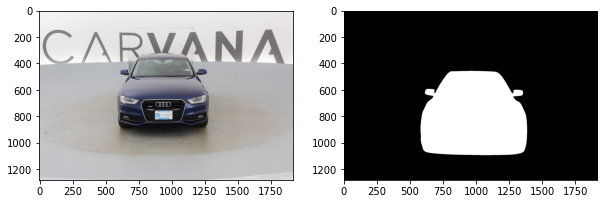

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
%matplotlib inline


plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('/content/drive/My Drive/Colab Notebooks/train/train_hq/train_hq/0cdf5b5d0ce1_01.jpg'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('/content/drive/My Drive/Colab Notebooks/train/train_masks/train_masks/00087a6bd4dc_01_mask.gif'))
plt.imshow(mask, 'gray')

plt.show()

Рассчет IoU

In [3]:
def calc_iou(
    prediction: np.array,
    ground_truth: np.array
    ) -> np.array:
    """
    Function for computing IoU metrics.

    Args:
        prediction: batch of binarized predicted masks (either 0 or 1)
        ground_truth: batch of binary GT masks (either 0 or 1)
    Returns:
        calculated iou: np.array
    """
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

Библиотеки

In [4]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma   
)
from IPython.display import clear_output
import os

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

from torch.nn import Conv2d as Conv2D
import torch.nn.init as init

from torch.nn import Upsample

Модель UNet

In [5]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2, output_padding=(0,1)
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2, output_padding=(0,1)
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2, output_padding=(0,1)
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2, output_padding=(0,1)
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=8, out_channels=out_channels, kernel_size=1
        )
        self.conv_last = nn.Conv2d(features, 8, kernel_size = 3, padding=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2) 
        dec1 = self.upconv1(dec2)
        dec1 = dec1[:,:,:,:-1]
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec1 = self.conv_last(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [6]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """


class UNet_upsample(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet_upsample, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


Класс датасет

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, root_dir_img, root_dir_mask, transform):
        super(SegmentationDataset).__init__()
        self.root_dir_img = root_dir_img
        self.root_dir_mask = root_dir_mask
        
        self.files_img = sorted(os.listdir(self.root_dir_img))
        self.files_mask = sorted(os.listdir(self.root_dir_mask))
      
        self.aug = transform
        self.to_tensor = transforms.ToTensor() 
        self.final_transform = transforms.Compose([transforms.ToTensor(),])

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir_img,
                                self.files_img[idx])
        mask_name = os.path.join(self.root_dir_mask,
                                self.files_mask[idx])
      
        img = cv2.imread(img_name)

        cap = cv2.VideoCapture(mask_name) #imread не поддерживает gif, костыль
        ret, mask_ = cap.read()
        cap.release()

        if self.aug != None:
            augmented =  self.aug(image=img, mask=mask_)

            return (self.final_transform(augmented['image']), 
                    self.to_tensor(augmented['mask']))
        return self.final_transform(img), self.to_tensor(mask_)

    def __len__(self):
        return len(self.files_img)

Аугментация

In [8]:
aug = Compose([
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(
            p=0.5,
            alpha=120,
            sigma=120 * 0.05,
            alpha_affine=120 * 0.03
        ),
        GridDistortion(p=0.5) ], p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.5),    
    RandomGamma(p=0.5)])

In [9]:
transform_val = transforms.Compose([transforms.ToTensor()])

train_data = SegmentationDataset('/content/drive/My Drive/Colab Notebooks/train/train_hq/train_hq', 
                                 '/content/drive/My Drive/Colab Notebooks/train/train_masks/train_masks', 
                                 None)

val_data = SegmentationDataset('/content/drive/My Drive/Colab Notebooks/train/train_hq/train_hq_val', 
                              '/content/drive/My Drive/Colab Notebooks/train/train_masks/train_masks_val',
                               None)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=1)

Создание модели

In [ ]:
model = UNet(3,3)
model.cuda()

In [11]:
criterion = nn.BCELoss()

train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []}

In [12]:
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 10

Обучение

In [ ]:
for i in range(num_epochs):

    epoch_losses = []
    epoch_ious = []
    val_losses = []
    val_ious = []
    
    model.train()
    for k, (img, mask) in enumerate(train_loader):  
        optimizer.zero_grad()
        y_pred = model(img.cuda())

        loss = criterion(y_pred, mask.cuda())
        
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.1, 
                                  mask.numpy())
        epoch_ious.append(iou)
        if k % 500 == 0:
          torch.save(model.state_dict(), 'drive/MyDrive/Colab Notebooks/weights.h5f')
            
    print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))
    
    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_iou = np.mean(np.array(epoch_ious))
    hist['train_iou'].append(epoch_iou)
    hist['train_loss'].append(epoch_loss)
    with torch.no_grad():
        model.eval()
        for k, (img, mask) in enumerate(val_loader):
            y_pred = model(img.cuda())
            loss = criterion(y_pred, mask.cuda())
            iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
                                  mask.numpy())
            val_losses.append(loss.item())
            val_ious.append(iou)
            
            
            
    val_loss = np.mean(np.array(val_losses))
    val_iou = np.mean(np.array(val_ious))
    hist['val_loss'].append(val_loss)
    hist['val_iou'].append(val_iou)
    if i < (num_epochs - 1):
        clear_output()   
    

Сохранение весов

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/Colab Notebooks/weights.h5f')

Загрузка сохраненной модели

In [18]:
model.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/weights.h5f'))

<All keys matched successfully>

Изменение размера предсказанной маски

In [53]:
'''img = torch.permute(img, (1, 2, 0))
pred = model(img.cuda())[0][0].detach().cpu().numpy()
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((1280, 1918))])
plt.imshow(torch.squeeze(transform(pred)))'''

torch.Size([3, 1280, 1918])


RuntimeError: ignored